## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

import warnings
warnings.filterwarnings('ignore')

# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [118]:
def print_graphs(data):
    for i in range(0, 100):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 100):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 100):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [119]:
data_multi = np.load("../datasets/avi/multi/data_full.npy")
print(data_multi.shape)
data_multi = data_multi.reshape(data_multi.shape[0]*data_multi.shape[1], data_multi.shape[2])
data_multi = data_multi.reshape(-1, data_multi.shape[-1])
print(data_multi.shape)


(10, 10, 8192)
(100, 8192)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

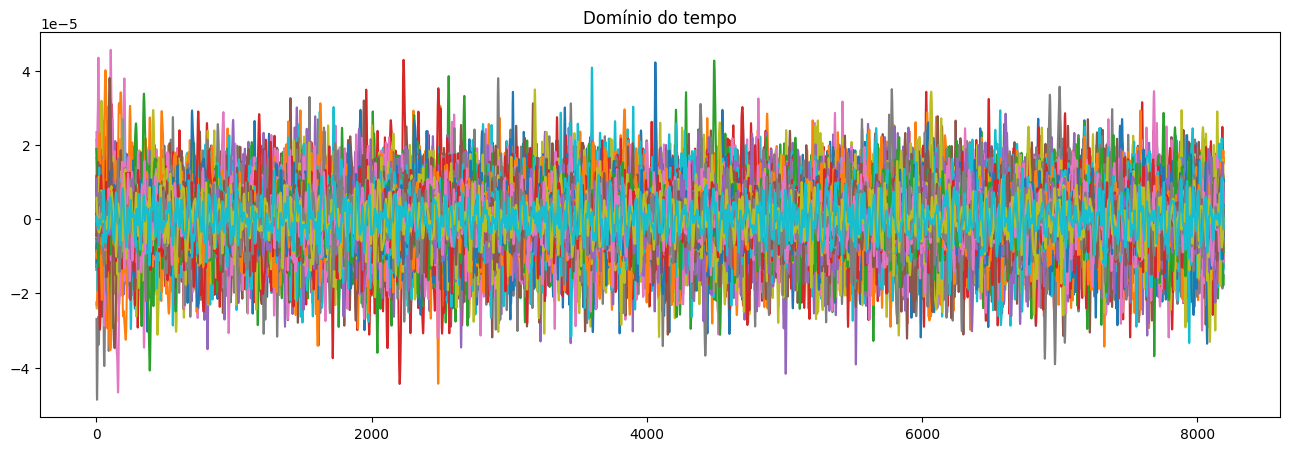

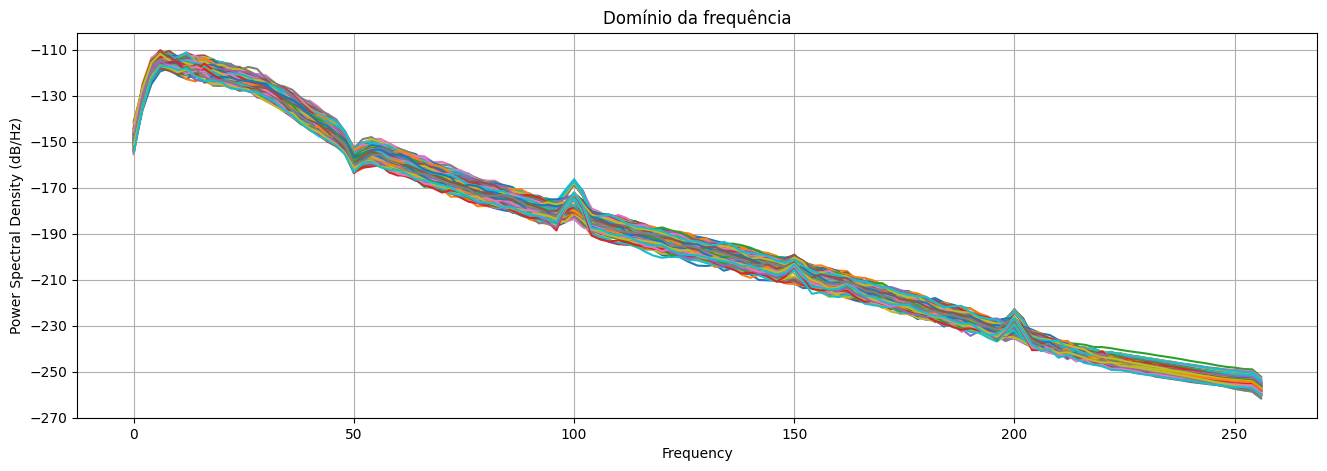

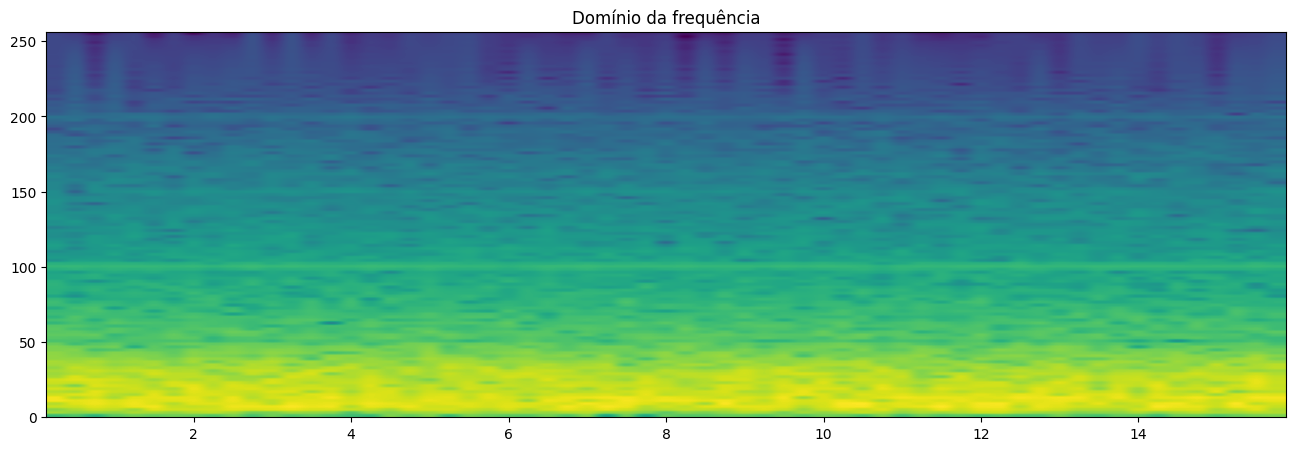

In [120]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data_multi)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [121]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [122]:
labels = np.load("../datasets/avi/multi/labels_full.npy")
print(labels.shape)

labels = labels.reshape(labels.shape[0] * labels.shape[1])
print(labels, labels.shape)
np.save("../datasets/avi/multi/labels_full_formated.npy", labels)


(10, 10)
[7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2 6.  6.5 7.5 7.
 6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2 6.  6.5
 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2
 6.  6.5 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.
 6.  8.2 6.  6.5 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2
 9.3 6.  6.  8.2 6.  6.5 7.5 7.  6.  6. ] (100,)


In [123]:
# método para transformar labels categóricos

data_correct = data_multi.reshape(data_multi.shape[0], 1, data_multi.shape[1])

le = LabelEncoder()

events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(100, dtype=int),
    le.fit_transform(labels))
)

event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


Number of events,100
Events,6: 406.5: 57: 107.5: 158.2: 259.3: 5
Time range,0.000 – 15.998 s
Baseline,off


In [124]:
# for i in range(len(mne_data)):
#     # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
#     view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13, verbose=False)
#     view.plot(show=False)
#     print()
#     plt.title('Domínio da frequência')
#     plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--', color='green')
#     plt.show()
# print()

### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

In [125]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="mne_data_multi.fif", overwrite=True)

Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)

Overwriting existing file.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
